<a href="https://colab.research.google.com/github/samyon7/ML/blob/master/StyleGan_Components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>StyleGAN Components</b><br>
--
AUTHOR : HAMORA HADI

In [4]:
# First import the libraries!
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import truncnorm

CREATE ANY FUNCTION PLZ!

In [5]:
# Function for visualizing image!
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

# Function for creating truncated noise vectors
def get_truncated_noise(n_samples, z_dim, truncation):
    truncated_noise = truncnorm.rvs(-1*truncation, truncation, size=(n_samples, z_dim))

    return torch.Tensor(truncated_noise)

In [7]:
assert tuple(get_truncated_noise(n_samples=10, z_dim=5, truncation=0.7).shape) == (10, 5)
simple_noise = get_truncated_noise(n_samples=1000, z_dim=10, truncation=0.2)
assert simple_noise.max() > 0.199 and simple_noise.max() < 2
assert simple_noise.min() < -0.199 and simple_noise.min() > -0.2
assert simple_noise.std() > 0.113 and simple_noise.std() < 0.117\

The next component you need to implement is the mapping network. It takes the noise vector, z, and maps it to an intermediate noise vector, w. This makes it so z can be represented in a more disentangled space which makes the features easier to control later.

In [8]:
# This code should be five lines. 2. You need 3 linear layers and should use ReLU activations. 3. Your linear layers should be input -> hidden_dim -> hidden_dim -> output.
class MappingLayers(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
        )

    def forward(self, noise):
        return self.mapping(noise)
    
    def get_mapping(self):
        return self.mapping

In [9]:
map_fn = MappingLayers(10,20,30)
assert tuple(map_fn(torch.randn(2, 10)).shape) == (2, 30)
assert len(map_fn.mapping) > 4
outputs = map_fn(torch.randn(1000, 10))
assert outputs.std() > 0.05 and outputs.std() < 0.3
assert outputs.min() > -2 and outputs.min() < 0
assert outputs.max() < 2 and outputs.max() > 0
layers = [str(x) for x in map_fn.get_mapping()]
assert layers == ['Linear(in_features=10, out_features=20, bias=True)', 
                  'ReLU()', 
                  'Linear(in_features=20, out_features=20, bias=True)', 
                  'ReLU()', 
                  'Linear(in_features=20, out_features=30, bias=True)']

Next, you will implement the random noise injection that occurs before every AdaIN block. To do this, you need to create a noise tensor that is the same size as the current feature map (image).

In [10]:
# The weight should have the shape (1, channels, 1, 1).
class InjectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(
            torch.randn(channels)[None, :, None, None] 
        )

    def forward(self, image):
        noise_shape = (image.shape[0],1,image.shape[2],image.shape[3])
        noise = torch.randn(noise_shape, device=image.device)
        return image + self.weight * noise 
    
    def get_weight(self):
        return self.weight
    
    def get_self(self):
        return self

In [11]:
test_noise_channels = 3000
test_noise_samples = 20
fake_images = torch.randn(test_noise_samples, test_noise_channels, 10, 10)
inject_noise = InjectNoise(test_noise_channels)
assert torch.abs(inject_noise.weight.std() - 1) < 0.1
assert torch.abs(inject_noise.weight.mean()) < 0.1
assert type(inject_noise.get_weight()) == torch.nn.parameter.Parameter
assert tuple(inject_noise.weight.shape) == (1, test_noise_channels, 1, 1)
inject_noise.weight = nn.Parameter(torch.ones_like(inject_noise.weight))
assert torch.abs((inject_noise(fake_images) - fake_images)).mean() > 0.1
assert torch.abs((inject_noise(fake_images) - fake_images).std(0)).mean() > 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(1)).mean() < 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(2)).mean() > 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(3)).mean() > 1e-4
per_channel_change = (inject_noise(fake_images) - fake_images).mean(1).std()
assert per_channel_change > 0.9 and per_channel_change < 1.1
inject_noise.weight = nn.Parameter(torch.zeros_like(inject_noise.weight))
assert torch.abs((inject_noise(fake_images) - fake_images)).mean() < 1e-4
assert len(inject_noise.weight.shape) == 4

Success!


<b>Adaptive Instance Normalization (AdaIN)</b><br>
The next component you will implement is AdaIN. To increase control over the image, you inject w — the intermediate noise vector — multiple times throughout StyleGAN.

In [12]:
# Remember the equation for AdaIN. 2. The instance normalized image, style scale, and style shift have already been calculated for you.
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        transformed_image = style_scale * normalized_image + style_shift
        return transformed_image
    
    def get_style_scale_transform(self):
        return self.style_scale_transform
    
    def get_style_shift_transform(self):
        return self.style_shift_transform
    
    def get_self(self):
        return self 

In [14]:
w_channels = 50
image_channels = 20
image_size = 30
n_test = 10
adain = AdaIN(image_channels, w_channels)
test_w = torch.randn(n_test, w_channels)
assert adain.style_scale_transform(test_w).shape == adain.style_shift_transform(test_w).shape
assert adain.style_scale_transform(test_w).shape[-1] == image_channels
assert tuple(adain(torch.randn(n_test, image_channels, image_size, image_size), test_w).shape) == (n_test, image_channels, image_size, image_size)

w_channels = 3
image_channels = 2
image_size = 3
n_test = 1
adain = AdaIN(image_channels, w_channels)

adain.style_scale_transform.weight.data = torch.ones_like(adain.style_scale_transform.weight.data) / 4
adain.style_scale_transform.bias.data = torch.zeros_like(adain.style_scale_transform.bias.data)
adain.style_shift_transform.weight.data = torch.ones_like(adain.style_shift_transform.weight.data) / 5
adain.style_shift_transform.bias.data = torch.zeros_like(adain.style_shift_transform.bias.data)
test_input = torch.ones(n_test, image_channels, image_size, image_size)
test_input[:, :, 0] = 0
test_w = torch.ones(n_test, w_channels)
test_output = adain(test_input, test_w)
assert(torch.abs(test_output[0, 0, 0, 0] - 3 / 5 + torch.sqrt(torch.tensor(9 / 8))) < 1e-4)
assert(torch.abs(test_output[0, 0, 1, 0] - 3 / 5 - torch.sqrt(torch.tensor(9 / 32))) < 1e-4)

The final StyleGAN component that you will create is progressive growing. This helps StyleGAN to create high resolution images by gradually doubling the image's size until the desired size.

In [15]:
# You will start by creating a block for the StyleGAN generator
class MicroStyleGANGeneratorBlock(nn.Module):
    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample
        if self.use_upsample:
            self.upsample = nn.Upsample((starting_size), mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) 
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x
    
    def get_self(self):
        return self;

In [16]:
test_stylegan_block = MicroStyleGANGeneratorBlock(in_chan=128, out_chan=64, w_dim=256, kernel_size=3, starting_size=8)
test_x = torch.ones(1, 128, 4, 4)
test_x[:, :, 1:3, 1:3] = 0
test_w = torch.ones(1, 256)
test_x = test_stylegan_block.upsample(test_x)
assert tuple(test_x.shape) == (1, 128, 8, 8)
assert torch.abs(test_x.mean() - 0.75) < 1e-4
test_x = test_stylegan_block.conv(test_x)
assert tuple(test_x.shape) == (1, 64, 8, 8)
test_x = test_stylegan_block.inject_noise(test_x)
test_x = test_stylegan_block.activation(test_x)
assert test_x.min() < 0
assert -test_x.min() / test_x.max() < 0.4
test_x = test_stylegan_block.adain(test_x, test_w) 
foo = test_stylegan_block(torch.ones(10, 128, 4, 4), torch.ones(10, 256))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


StyleGAN starts with a constant 4 x 4 (x 512 channel) tensor which is put through an iteration of the generator without upsampling. The output is some noise that can then be transformed into a blurry 4 x 4 image. This is where the progressive growing process begins. The 4 x 4 noise can be further passed through a generator block with upsampling to produce an 8 x 8 output. However, this will be done gradually.<br>
You will simulate progressive growing from an 8 x 8 image to a 16 x 16 image. Instead of simply passing it to the generator block with upsampling, StyleGAN gradually trains the generator to the new size by mixing in an image that was only upsampled. By mixing an upsampled 8 x 8 image (which is 16 x 16) with increasingly more of the 16 x 16 generator output, the generator is more stable as it progressively trains.

In [22]:
class MicroStyleGANGenerator(nn.Module):
    def __init__(self, 
                 z_dim, 
                 map_hidden_dim,
                 w_dim,
                 in_chan,
                 out_chan, 
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        self.block0 = MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)
        self.block1 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8)
        self.block2 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16)
        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.alpha = 0.2

    def upsample_to_match_size(self, smaller_image, bigger_image):
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        x = self.starting_constant
        w = self.map(noise)
        x = self.block0(x, w)
        x_small = self.block1(x, w)
        x_small_image = self.block1_to_image(x_small)
        x_big = self.block2(x_small, w) 
        x_big_image = self.block2_to_image(x_big)
        x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image)
        interpolation = self.alpha * (x_big_image) + (1-self.alpha) * (x_small_upsample)
        if return_intermediate:
            return interpolation, x_small_upsample, x_big_image
        return interpolation
    
    def get_self(self):
        return self;

In [23]:
z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
)

test_samples = 10
test_result = mu_stylegan(get_truncated_noise(test_samples, z_dim, truncation))
assert tuple(test_result.shape) == (test_samples, out_chan, 16, 16)
mu_stylegan.alpha = 1.
test_result, _, test_big =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_big).mean() < 0.001
mu_stylegan.alpha = 0.
test_result, test_small, _ =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_small).mean() < 0.001

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


<b>Now Run!</b><br>
You can also visualize what this randomly initiated generator can produce. The code will automatically interpolate between different values of alpha so that you can intuitively see what it means to mix the low-resolution and high-resolution images using different values of alpha. In the generated image, the samples start from low alpha values and go to high alpha values.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


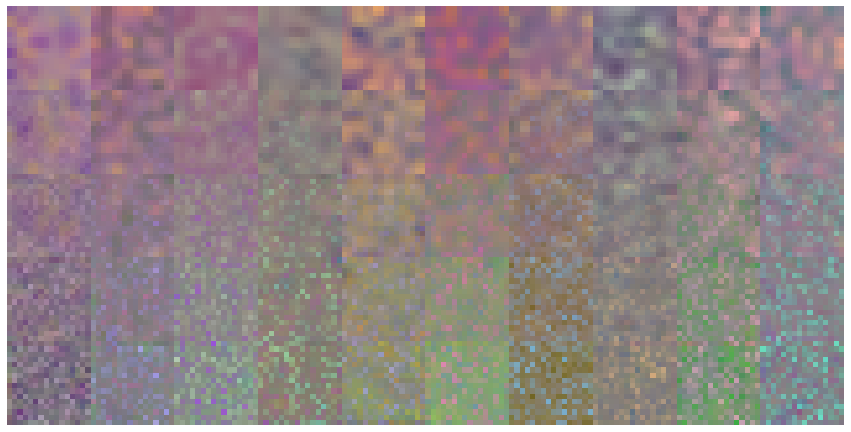

In [24]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise, 
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
mu_stylegan = mu_stylegan.train()